We provide this notebook as a quick-start demonstration. While we did not explicitly evaluate detection performance at test time in the paper, our method should still be effective in such scenarios.

The notebook includes an example of test-time detection using the pre-trained model from our paper. For simplicity, we assume a low poisoning rate, allowing us to use the default implementation, which computes the backdoor score using the same batch of data as a reference. However, if this assumption does not hold (e.g., when a batch contains an extremely large number of poisoned samples), using a small clean subset as a reference may be necessary.

# Load pretrained weights

In [1]:
import torch

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [2]:
ckpt_path = 'PATH/TO/CHECKPOINT/*.PT'

In [3]:
import models
from functools import partial

vision_model_config = partial(
    models.modified_resnet.ModifiedResNet, 
    layers=[3,4,6,3],
    heads=32,
    width=64,
    image_size=224,
    output_dim=1024,
    get_features=True,
)

text_model_config = partial(
    models.transformer.TextTransformer, 
    context_length=77,
    vocab_size=49408,
    width=512,
    heads=8,
    layers=12,
    output_dim=1024
)

model = models.clip_model.CLIP(vision_model_config, text_model_config)
msg = model.load_state_dict(torch.load(ckpt_path))
model = model.to(device)
model = model.eval()
msg

/home/hanxunh/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/hanxunh/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


<All keys matched successfully>

# ImageNet with BadNets trigger

In [4]:
dataset_path = 'PATH/TO/ImageNet/val'
test_poison_rate = 0.0001 # 0.01%

In [5]:
import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

def _convert_to_rgb(image):
    return image.convert('RGB')

transform = transforms.Compose(
    [
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop((224, 224)),
        _convert_to_rgb,
        transforms.ToTensor(),
    ]
)

test_set = datasets.in1k_backdoor_zeroshot.ImageNetBadNetsZeroShot(
    root=dataset_path,
    transform=transform,
    backdoor_label_idx=954,
    test_poison_rate=test_poison_rate,
)

test_loader = DataLoader(test_set, batch_size=128, num_workers=4, shuffle=True)

# poison_indices stores which index is selected to add the trigger 
poison_indices = test_set.poison_indices 
len(test_set)

/home/hanxunh/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


49950

In [6]:
'No.of backdoor samples: {} Poisoning rate: {}%'.format(len(poison_indices), round(len(poison_indices)/len(test_set)*100, 2))


'No.of backdoor samples: 4 Poisoning rate: 0.01%'

# Visualize backdoor samples

In [7]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


def show_image_grid(imgs, nrow=10, figsize=(10, 10), dpi=200, filename=None):
    grid_img = torchvision.utils.make_grid(imgs, nrow=nrow)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img.permute(1, 2, 0).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()
    
def get_images(data, idxs):
    images = []
    for idx in idxs:
        image = data.__getitem__(idx)[0]
        images.append(image)
    images = torch.stack(images)
    return images


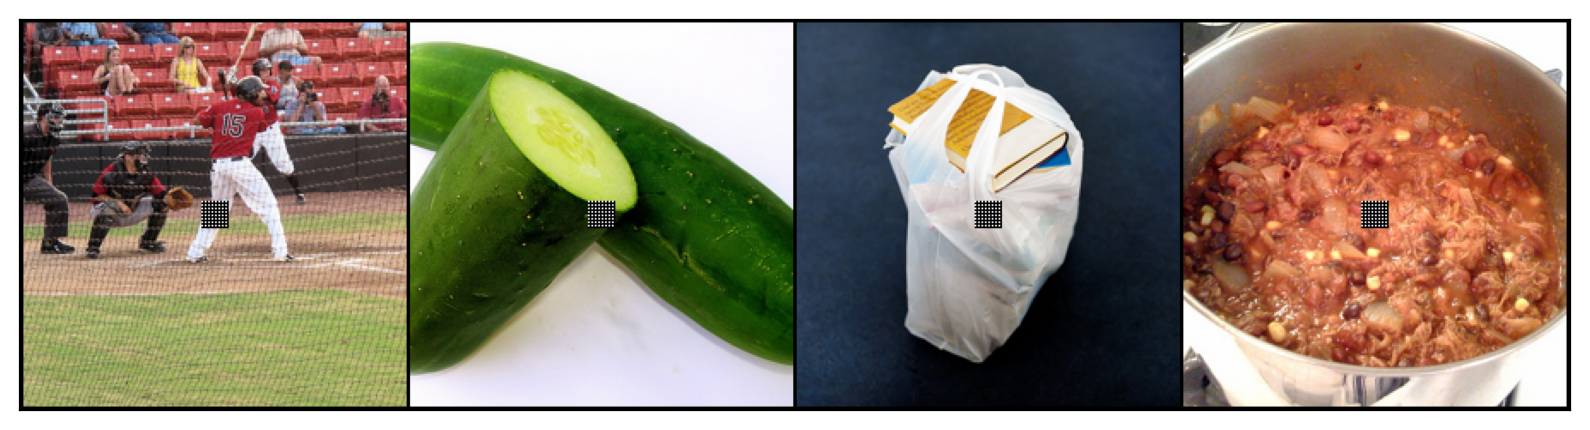

In [8]:
backdoor_images = get_images(test_set, poison_indices[:20])
show_image_grid(backdoor_images)

# Trigger patch is in the center of the image.

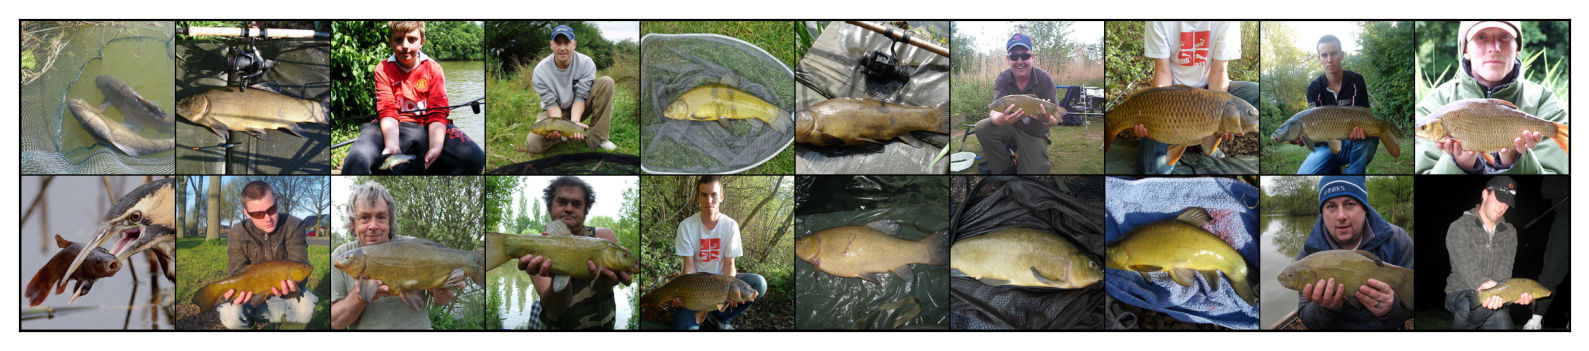

In [ ]:
images = get_images(test_set, list(range(20)))
show_image_grid(images)


# Verify the backdoor prediction


In [10]:
from datasets.zero_shot_metadata import zero_shot_meta_dict
from open_clip import get_tokenizer
import torch.nn.functional as F

# Build zero-shot template

clip_tokenizer = get_tokenizer('RN50')
classnames = list(zero_shot_meta_dict['IMAGENET_CLASSNAMES'])
templates = zero_shot_meta_dict['OPENAI_IMAGENET_TEMPLATES']

with torch.no_grad():
    use_format = isinstance(templates[0], str)
    zeroshot_weights = []
    for classname in classnames:
        texts = [template.format(classname) if use_format else template(classname) for template in templates]
        texts = clip_tokenizer(texts).to(device) if clip_tokenizer is not None else texts
        class_embeddings = model.encode_text(texts)
        class_embedding = F.normalize(class_embeddings, dim=-1).mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
zeroshot_weights.shape



torch.Size([1024, 1000])

In [11]:
import util
from tqdm import tqdm

# Check clean acc

acc1_meter = util.AverageMeter()

for images, labels in tqdm(test_loader):
    images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    with torch.no_grad():
        out = model(images)
    image_features = out['image_features']
    logits = 100. * image_features @ zeroshot_weights
    acc1 = util.accuracy(logits, labels, topk=(1,))[0]
    acc1_meter.update(acc1.item(), n=images.shape[0])
    
acc1_meter.avg

  0%|          | 0/391 [00:00<?, ?it/s]/home/hanxunh/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 391/391 [04:40<00:00,  1.39it/s]


0.17011011011488325

In [12]:
# Prediction on backdoor images should match with backdoor label (954)

with torch.no_grad():
    backdoor_embeddings = model.encode_image(backdoor_images.to(device), normalize=True)
    logits = 100. * backdoor_embeddings @ zeroshot_weights
    print(logits.argmax(dim=1))
    

tensor([954, 954, 954, 954], device='cuda:0')


# Detection

In [13]:
import backdoor_sample_detector

compute_mode = 'donot_use_mm_for_euclid_dist' # Better precision
detector = backdoor_sample_detector.DAODetector(
    k=16, est_type='mle', gather_distributed=False, compute_mode=compute_mode
)


In [14]:
import util
import numpy as np
from tqdm import tqdm

test_set.get_index = True
test_loader = DataLoader(test_set, batch_size=128, num_workers=4, shuffle=True)

scores = np.zeros(len(test_set))

for idx, images, labels in tqdm(test_loader):
    images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    batch_scores = detector(model=model, images=images, texts=None)
    for j, i in enumerate(idx):
        scores[i] = batch_scores[j]

100%|██████████| 391/391 [04:43<00:00,  1.38it/s]


In [15]:
scores

array([-0.08579378, -0.06483869, -0.04932504, ...,  0.0138177 ,
        0.0029569 ,  0.17429918])

In [16]:
scores[np.array(poison_indices)]

array([1.75262761, 2.1876936 , 1.79278374, 2.02195501])

In [17]:
# Lets check AUROC
from sklearn.metrics import auc, roc_curve


y = np.zeros((len(test_set)))
y[np.array(poison_indices)] = 1 # Set backdoor to 1 (positive)

fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

1.0